In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from ADF_test import is_stationary
import pmdarima as pm
from pmdarima.model_selection import train_test_split
import numpy as np
from sklearn.metrics import r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = 'plotly_white'
plot_template = dict(
    layout=go.Layout({
        'font_size': 8,
        'xaxis_title_font_size': 8,
        'yaxis_title_font_size': 8,
        }   
))

In [2]:
hydro_station = 'tangnaihai'
df = pd.read_csv(f'../data/{hydro_station}_natural_monthly_flow.csv', parse_dates=['date'], index_col='date')
# compute the average flow before 2014-12-31
df_avg_before_2014 = df.loc[:'2014-12-31','flow(m^3/s)'].mean()
df.info()
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index, y=df['flow(m^3/s)'], mode='lines', name=f'{hydro_station} River'))
fig.add_shape(
    type="line",
    x0=df.index[0],
    y0=df_avg_before_2014,
    x1=df.index[-1],
    y1=df_avg_before_2014,
    line=dict(color="Red", width=2)
)

fig.update_layout(title=f'Yellow River Monthly Flow at {hydro_station}',
                   xaxis_title='Date',
                   yaxis_title='Flow (m^3/s)')
fig.show()



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 840 entries, 1950-01-01 to 2019-12-01
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   flow(m^3/s)  840 non-null    float64
dtypes: float64(1)
memory usage: 45.4 KB


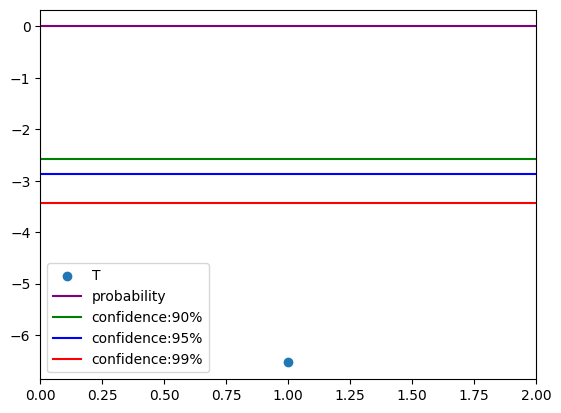

True

In [3]:
is_stationary(df['flow(m^3/s)'])


In [4]:
train,test = train_test_split(df, test_size=12*5)
train.info()
test.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 780 entries, 1950-01-01 to 2014-12-01
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   flow(m^3/s)  780 non-null    float64
dtypes: float64(1)
memory usage: 12.2 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 2015-01-01 to 2019-12-01
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   flow(m^3/s)  60 non-null     float64
dtypes: float64(1)
memory usage: 960.0 bytes


In [31]:
model = pm.auto_arima(train, seasonal=True, m=12, trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

model.summary()
train_pred = model.predict_in_sample()
test_pred = model.predict(n_periods=len(test))

# calculate the R2

train_r2 = r2_score(train, train_pred)
test_r2 = r2_score(test, test_pred)
print(f'Train R2: {train_r2}, Test R2: {test_r2}')

# visualize the results using plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=train.index, y=train['flow(m^3/s)'], mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=test.index, y=test['flow(m^3/s)'], mode='lines', name='Test'))
fig.add_trace(go.Scatter(x=test.index, y=test_pred, mode='lines', name='Test Pred'))
fig.add_trace(go.Scatter(x=train.index, y=train_pred, mode='lines', name='Train Pred'))
fig.show()



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.41 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=11931.167, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=11131.456, Time=0.57 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=11296.331, Time=0.47 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=12666.608, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=11383.594, Time=0.04 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=11089.364, Time=2.71 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=11116.075, Time=2.09 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=10972.933, Time=0.82 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=11217.942, Time=0.45 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=11016.375, Time=1.75 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=11183.731, Time=1.12 sec
 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=2.01 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(2,0,0)(1,0,1)[12

In [6]:
modes = [
    'multiplicative',
    'additive'
]
for mode in modes:
    val_years = np.arange(2009,2015)
    test_pred = pd.DataFrame()
    test_obs = df.loc["2009-01-01":"2014-12-31",:]
    train_r2_list = []
    for year in val_years:
        train = df.loc[:"{}-12-31".format(year-1),:]
        test = df.loc["{}-01-01".format(year):"{}-12-31".format(year),:]
        decomposition = seasonal_decompose(train['flow(m^3/s)'], model=mode, period=12,extrapolate_trend=1)
        trend = decomposition.trend
        seasonal = decomposition.seasonal
        residual = decomposition.resid
    
        # fit the ARIMA model to the trend component
        model = pm.auto_arima(trend, seasonal=False, trace=True,
                          error_action='ignore',  
                            suppress_warnings=True, 
                            stepwise=True)
        model.summary()
        train_trend_pred = model.predict_in_sample()
        test_trend_pred = model.predict(n_periods=len(test))
        # fit the ARIMA model to the seasonal component
        model = pm.auto_arima(seasonal, seasonal=True, trace=True,
                          error_action='ignore',  
                            suppress_warnings=True, 
                            stepwise=True)
        model.summary()
        train_seasonal_pred = model.predict_in_sample()
        test_seasonal_pred = model.predict(n_periods=len(test))
        # fit the ARIMA model to the residual component
        model = pm.auto_arima(residual, seasonal=False, trace=True,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True)
        model.summary()
        train_residual_pred = model.predict_in_sample()
        test_residual_pred = model.predict(n_periods=len(test))
        # combine the trend, seasonal, and residual components
        if mode == 'multiplicative':
            train_pred_year = train_trend_pred * train_seasonal_pred * train_residual_pred
            test_pred_year = test_trend_pred * test_seasonal_pred * test_residual_pred
        else:
            train_pred_year = train_trend_pred + train_seasonal_pred + train_residual_pred
            test_pred_year = test_trend_pred + test_seasonal_pred + test_residual_pred

        train_pred_year.index = train.index
        train_pred_year.name = "SimFlow(m^3/s)"
        train_result = pd.concat([train,train_pred_year],axis=1)
        train_result.to_csv(f'../result/ARIMAPredData/seasonal_decompose_{mode}_arima_train_sim_{hydro_station}_before_{year}.csv')
        train_r2 = r2_score(train['flow(m^3/s)'], train_pred_year)
        train_r2_list.append(train_r2)
        test_pred_year.index = test.index
        test_pred_year.name = "flow(m^3/s)"
        test_pred = pd.concat([test_pred,test_pred_year])

    print(sum(train_r2_list)/len(train_r2_list))
    print(test_pred)
    print(r2_score(test_obs,test_pred)) # 0.6934 multiplicative;0.5988 additive
    test_pred.index.name = 'date'
    test_pred.to_csv(f'../result/ARIMAPredData/seasonal_decompose_{mode}_arima_pred_{hydro_station}_2009_2014.csv')

    # visualize the results using plotly
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=test_obs.index, y=test_obs['flow(m^3/s)'], mode='lines', name='Observed'))
    fig.add_trace(go.Scatter(x=test_pred.index, y=test_pred['flow(m^3/s)'], mode='lines', name='Predicted'))
    fig.show()


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6764.492, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6203.954, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6762.494, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6066.154, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=5985.301, Time=0.10 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=5947.632, Time=0.14 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=5917.121, Time=0.18 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=5915.121, Time=0.10 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=5945.632, Time=0.15 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=0.43 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.32 s

C:\Users\ZJY\AppData\Local\Temp\ipykernel_33632\3944882787.py:58: FutureWarning:

The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.



 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6878.455, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6301.050, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6876.506, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6158.788, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=6074.250, Time=0.10 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=6033.604, Time=0.14 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=5998.565, Time=0.15 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=5996.575, Time=0.09 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=6031.619, Time=0.08 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=0.48 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.36 sec

Best model:  ARIMA(5,1,0)(0,0,0)[0]    

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6764.492, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6203.954, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6762.494, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6066.154, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=5985.301, Time=0.11 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=5947.632, Time=0.15 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=5917.121, Time=0.17 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.73 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.59 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=5915.121, Time=0.14 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=5945.632, Time=0.08 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=0.48 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.37 s

C:\Users\ZJY\AppData\Local\Temp\ipykernel_33632\3944882787.py:58: FutureWarning:

The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.



 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6878.455, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6301.050, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6876.506, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6158.788, Time=0.10 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=6074.250, Time=0.11 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=6033.604, Time=0.15 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=5998.565, Time=0.18 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.61 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=5996.575, Time=0.09 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=6031.619, Time=0.09 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=0.59 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.48 sec

Best model:  ARIMA(5,1,0)(0,0,0)[0]    

In [16]:
modes = ['multiplicative','additive']
for mode in modes:
    pred_years = [2015,2016,2017,2018,2019]
    test_pred = pd.DataFrame()
    test_obs = df.loc["2015-01-01":"2019-12-31",:]
    train_r2_list = []
    for year in pred_years:
        train = df.loc[:"{}-12-31".format(year-1),:]
        test = df.loc["{}-01-01".format(year):"{}-12-31".format(year),:]
        # decompose the data using seasonal_decompose
        decomposition = seasonal_decompose(train['flow(m^3/s)'], model=mode, period=12,extrapolate_trend=1)
        # decomposition = seasonal_decompose(train['flow(m^3/s)'], model='additive', period=12,extrapolate_trend=1)
        # extract the trend component
        trend = decomposition.trend
        seasonal = decomposition.seasonal
        residual = decomposition.resid
        print(trend)

    
        # fit the ARIMA model to the trend component
        model = pm.auto_arima(trend, seasonal=False, trace=True,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True)
        model.summary()
        train_trend_pred = model.predict_in_sample()
        test_trend_pred = model.predict(n_periods=len(test))
        # fit the ARIMA model to the seasonal component
        model = pm.auto_arima(seasonal, seasonal=True, trace=True,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True)
        model.summary()
        train_seasonal_pred = model.predict_in_sample()
        test_seasonal_pred = model.predict(n_periods=len(test))
        # fit the ARIMA model to the residual component
        model = pm.auto_arima(residual, seasonal=False, trace=True,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True)
        model.summary()
        train_residual_pred = model.predict_in_sample()
        test_residual_pred = model.predict(n_periods=len(test))
        # combine the trend, seasonal, and residual components
        if mode == 'multiplicative':
            train_pred_year = train_trend_pred * train_seasonal_pred * train_residual_pred
            test_pred_year = test_trend_pred * test_seasonal_pred * test_residual_pred
        else:
            train_pred_year = train_trend_pred + train_seasonal_pred + train_residual_pred
            test_pred_year = test_trend_pred + test_seasonal_pred + test_residual_pred

        train_pred_year.index = train.index
        train_pred_year.name = "SimFlow(m^3/s)"
        train_result = pd.concat([train,train_pred_year],axis=1)
        train_result.to_csv(f'../result/ARIMAPredData/seasonal_decompose_{mode}_arima_train_sim_{hydro_station}_before_{year}.csv')
        train_r2 = r2_score(train['flow(m^3/s)'], train_pred_year)
        train_r2_list.append(train_r2)
        test_pred_year.index = test.index
        test_pred_year.name = "flow(m^3/s)"
        test_pred = pd.concat([test_pred,test_pred_year])

    print(sum(train_r2_list)/len(train_r2_list))
    print(r2_score(test_obs,test_pred)) # 0.6934 multiplicative;0.5988 additive
    test_pred.index.name = 'date'
    test_pred.to_csv(f'../result/ARIMAPredData/seasonal_decompose_{mode}_arima_pred_{hydro_station}_2015_2019.csv')

    # visualize the results using plotly
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=test_obs.index, y=test_obs['flow(m^3/s)'], mode='lines', name='Observed'))
    fig.add_trace(go.Scatter(x=test_pred.index, y=test_pred['flow(m^3/s)'], mode='lines', name='Predicted'))
    fig.show()
    


date
1950-01-01    705.294220
1950-02-01    700.628644
1950-03-01    695.963068
1950-04-01    691.297491
1950-05-01    686.631915
                 ...    
2014-08-01    672.024750
2014-09-01    692.477439
2014-10-01    712.930127
2014-11-01    733.382815
2014-12-01    753.835503
Name: trend, Length: 780, dtype: float64
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=12331.962, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=10117.934, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=7462.833, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=6804.790, Time=0.11 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=6679.620, Time=0.19 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=6562.567, Time=0.1

C:\Users\ZJY\AppData\Local\Temp\ipykernel_66196\499651426.py:60: FutureWarning:

The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=12514.729, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=10275.063, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=7572.963, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=6907.137, Time=0.11 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=6779.274, Time=0.20 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=6659.367, Time=0.17 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=6628.634, Time=0.35 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.62 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0] intercept
Total fit time: 2.494 seconds
Performing stepwise search to mi

date
1950-01-01    705.294220
1950-02-01    700.628644
1950-03-01    695.963068
1950-04-01    691.297491
1950-05-01    686.631915
                 ...    
2014-08-01    672.024750
2014-09-01    692.477439
2014-10-01    712.930127
2014-11-01    733.382815
2014-12-01    753.835503
Name: trend, Length: 780, dtype: float64
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=12331.962, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=10117.934, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=7462.833, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=6804.790, Time=0.11 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=6679.620, Time=0.17 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=6562.567, Time=0.1

C:\Users\ZJY\AppData\Local\Temp\ipykernel_66196\499651426.py:60: FutureWarning:

The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=12514.729, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=10275.063, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=7572.963, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=6907.137, Time=0.11 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=6779.274, Time=0.21 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=6659.367, Time=0.17 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=6628.634, Time=0.32 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.70 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0] intercept
Total fit time: 2.515 seconds
Performing stepwise search to mi

In [1]:
bias_from_avg_mul = test_pred['flow(m^3/s)'] - df_avg_before_2014
test_pred['bias_from_avg_mul'] = bias_from_avg_mul
# Plot a box plot of the bias from the average flow
fig = px.box(test_pred, y='bias_from_avg_mul', title='Bias from the Average Flow')
fig.show()


NameError: name 'test_pred' is not defined

In [34]:
pred_years = [2015,2016,2017,2018,2019]
test_pred = pd.DataFrame()
test_obs = df.loc["2015-01-01":"2019-12-01",:]
train_r2_list = []
for year in pred_years:
    train = df.loc[:"{}-12-01".format(year-1),:]
    test = df.loc["{}-01-01".format(year):"{}-12-01".format(year),:]
    # decompose the data using seasonal_decompose
    # decomposition = seasonal_decompose(train['flow(m^3/s)'], model='multiplicative', period=12,extrapolate_trend=1)
    decomposition = seasonal_decompose(train['flow(m^3/s)'], model='additive', period=12,extrapolate_trend=1)
    # extract the trend component
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    print(trend)

    
    # fit the ARIMA model to the trend component
    model = pm.auto_arima(trend, seasonal=False, trace=True,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True)
    model.summary()
    train_trend_pred = model.predict_in_sample()
    test_trend_pred = model.predict(n_periods=len(test))
    # fit the ARIMA model to the seasonal component
    model = pm.auto_arima(seasonal, seasonal=False, trace=True,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True)
    model.summary()
    train_seasonal_pred = model.predict_in_sample()
    test_seasonal_pred = model.predict(n_periods=len(test))
    # fit the ARIMA model to the residual component
    model = pm.auto_arima(residual, seasonal=False, trace=True,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True)
    model.summary()
    train_residual_pred = model.predict_in_sample()
    test_residual_pred = model.predict(n_periods=len(test))
    # combine the trend, seasonal, and residual components
    # train_pred_year = train_trend_pred * train_seasonal_pred * train_residual_pred
    # test_pred_year = test_trend_pred * test_seasonal_pred * test_residual_pred
    train_pred_year = train_trend_pred + train_seasonal_pred + train_residual_pred
    test_pred_year = test_trend_pred + test_seasonal_pred + test_residual_pred

    train_pred_year.index = train.index
    train_pred_year.name = "SimFlow(m^3/s)"
    train_result = pd.concat([train,train_pred_year],axis=1)
    train_result.to_csv(f'../result/ARIMAPredData/seasonal_decompose_additive_arima_train_sim_{hydro_station}_before_{year}.csv')
    train_r2 = r2_score(train['flow(m^3/s)'], train_pred_year)
    train_r2_list.append(train_r2)
    test_pred_year.index = test.index
    test_pred_year.name = "flow(m^3/s)"
    test_pred = pd.concat([test_pred,test_pred_year])

print(sum(train_r2_list)/len(train_r2_list))
print(r2_score(test_obs,test_pred)) # 0.6934 multiplicative;0.5988 additive
test_pred.index.name = 'date'
test_pred.to_csv(f'../result/ARIMAPredData/seasonal_decompose_additive_arima_pred_{hydro_station}_2015_2019.csv')
# visualize the results using plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_obs.index, y=test_obs['flow(m^3/s)'], mode='lines', name='Observed'))
fig.add_trace(go.Scatter(x=test_pred.index, y=test_pred['flow(m^3/s)'], mode='lines', name='Predicted'))
fig.show()

date
1950-01-01    705.294220
1950-02-01    700.628644
1950-03-01    695.963068
1950-04-01    691.297491
1950-05-01    686.631915
                 ...    
2014-08-01    672.024750
2014-09-01    692.477439
2014-10-01    712.930127
2014-11-01    733.382815
2014-12-01    753.835503
Name: trend, Length: 780, dtype: float64
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=12331.962, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=10117.934, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=7462.833, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=6804.790, Time=0.12 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=6679.620, Time=0.17 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=6562.567, Time=0.1

C:\Users\ZJY\AppData\Local\Temp\ipykernel_75888\2352357125.py:56: FutureWarning:

The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.



 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=12514.729, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=10275.063, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=7572.963, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=6907.137, Time=0.12 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=6779.274, Time=0.19 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=6659.367, Time=0.17 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=6628.634, Time=0.33 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.59 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=inf, Time=0.10 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0] intercept
Total fit time: 2.403 seconds
Performing stepwise search to mi

In [35]:
bias_from_avg_add = test_pred['flow(m^3/s)'] - df_avg_before_2014
test_pred['bias_from_avg_add'] = bias_from_avg_add
# Plot two box plot of the bias_from_avg_add and bias_from_avg_mul
fig = go.Figure()
fig.add_trace(go.Box(y=bias_from_avg_mul, name='Multiplicative', marker_color='rgba(255, 140, 0, 0.6)'))
fig.add_trace(go.Box(y=bias_from_avg_add, name='Additive', marker_color='rgba(0, 128, 0, 0.6)'))
fig.update_layout(title='Bias from the Average Flow',
                  yaxis_title='Bias',
                  boxmode='group')
fig.show()

bias_from_avg_df = pd.DataFrame({'bias_from_avg_mul':bias_from_avg_mul, 'bias_from_avg_add':bias_from_avg_add})
bias_from_avg_df.to_csv(f'../result/ARIMAPredData/bias_from_avg_{hydro_station}.csv')

